In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from models import VGG16

import os
from tqdm import tqdm

/jun/anaconda3/envs/abaw1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vgg16 = VGG16(num_classes=88, use_pretrain=True)

In [3]:
# 데이터셋 경로 설정
dataset_train_path = os.path.join("mvtec_anomaly_detection_imagefolder", "train")
dataset_validation_path = os.path.join("mvtec_anomaly_detection_imagefolder", "validation")

# 이미지 변환 설정
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 데이터셋의 평균과 표준편차 사용
                                ])

# 데이터셋 로드
train_dataset = torchvision.datasets.ImageFolder(root=dataset_train_path, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=dataset_validation_path, transform=transform)

# 데이터 로더 설정
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# VGG16 모델 불러오기
# vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16 = VGG16(num_classes=88, use_pretrain=True)

# GPU를 사용할 수 있는 경우 GPU로 모델을 이동합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


In [4]:
train_dataset.classes

['bottle-broken_large',
 'bottle-broken_small',
 'bottle-contamination',
 'bottle-good',
 'cable-bent_wire',
 'cable-cable_swap',
 'cable-combined',
 'cable-cut_inner_insulation',
 'cable-cut_outer_insulation',
 'cable-good',
 'cable-missing_cable',
 'cable-missing_wire',
 'cable-poke_insulation',
 'capsule-crack',
 'capsule-faulty_imprint',
 'capsule-good',
 'capsule-poke',
 'capsule-scratch',
 'capsule-squeeze',
 'carpet-color',
 'carpet-cut',
 'carpet-good',
 'carpet-hole',
 'carpet-metal_contamination',
 'carpet-thread',
 'grid-bent',
 'grid-broken',
 'grid-glue',
 'grid-good',
 'grid-metal_contamination',
 'grid-thread',
 'hazelnut-crack',
 'hazelnut-cut',
 'hazelnut-good',
 'hazelnut-hole',
 'hazelnut-print',
 'leather-color',
 'leather-cut',
 'leather-fold',
 'leather-glue',
 'leather-good',
 'leather-poke',
 'metal_nut-bent',
 'metal_nut-color',
 'metal_nut-flip',
 'metal_nut-good',
 'metal_nut-scratch',
 'pill-color',
 'pill-combined',
 'pill-contamination',
 'pill-crack',
 'p

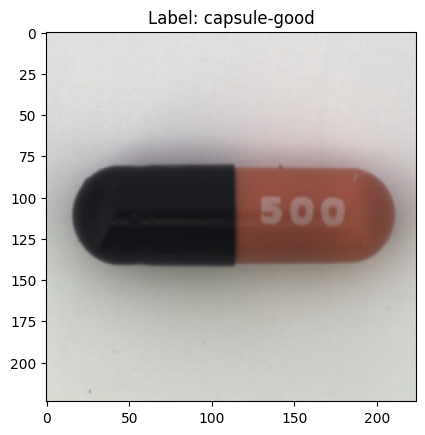

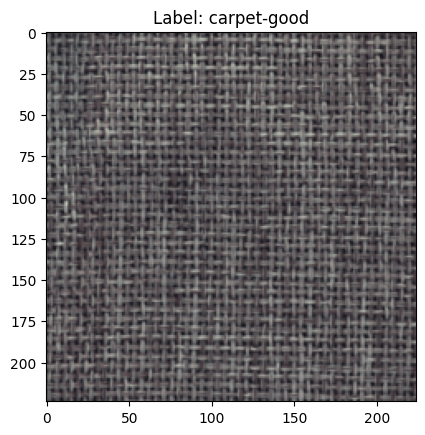

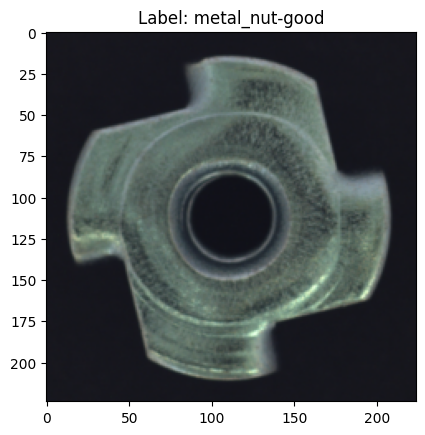

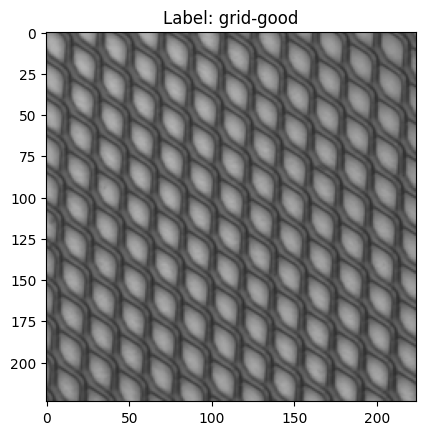

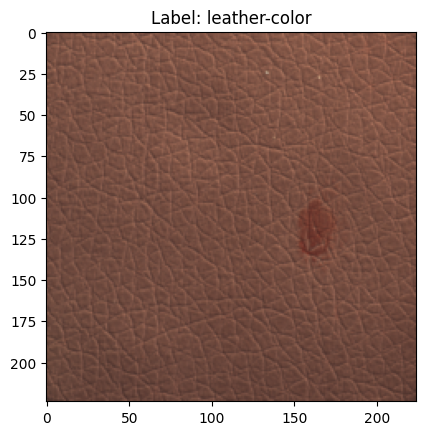

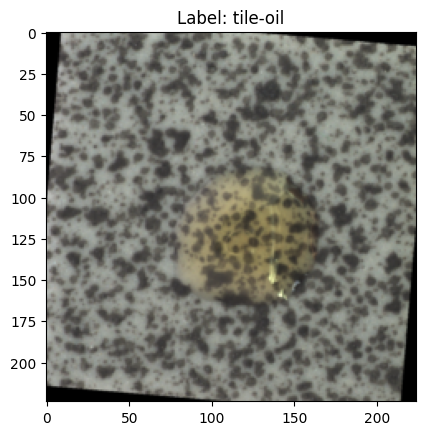

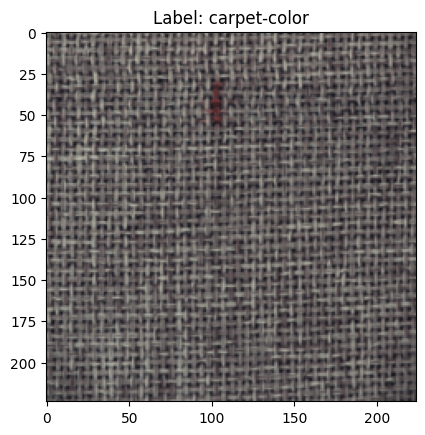

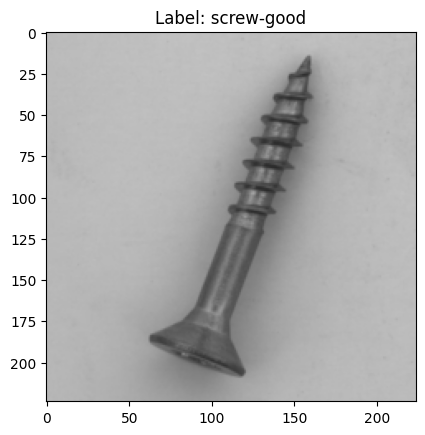

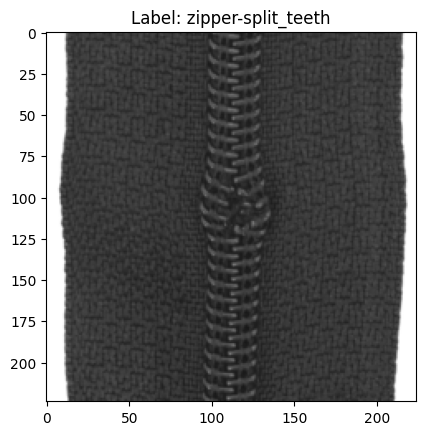

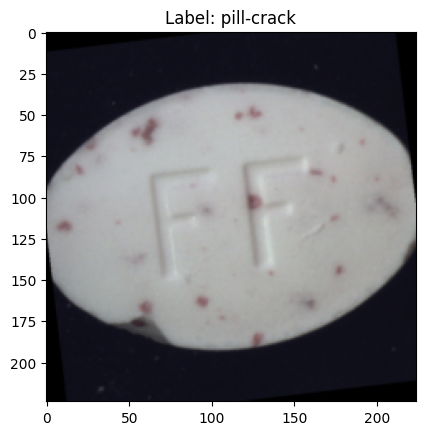

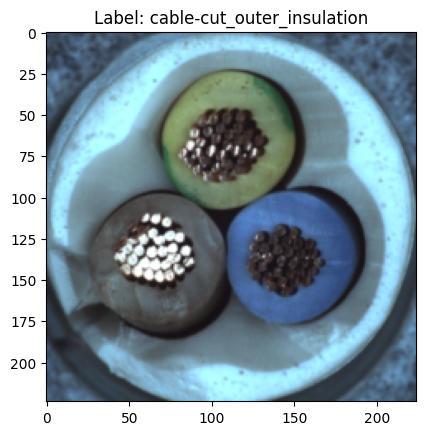

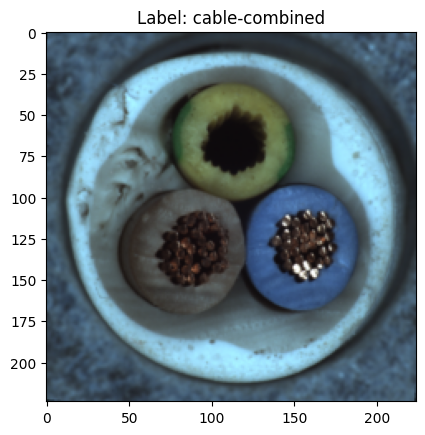

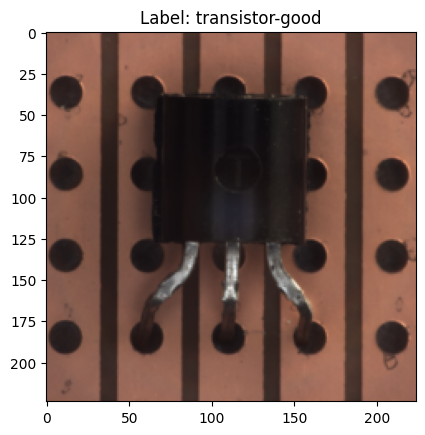

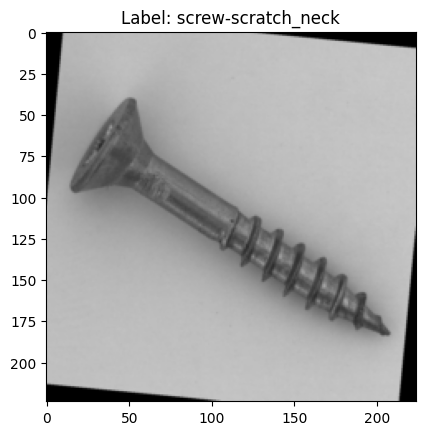

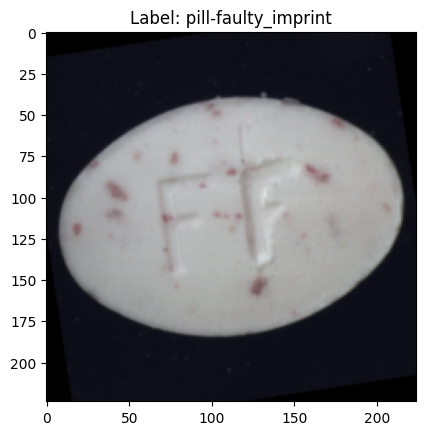

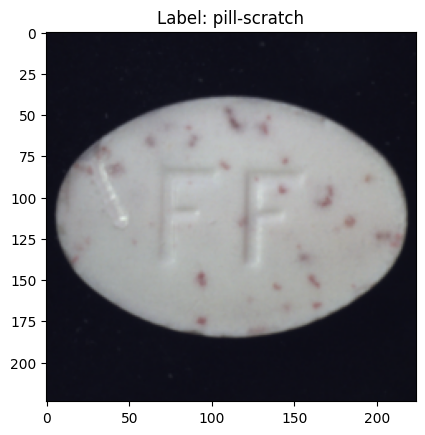

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로더에서 한 배치만 가져옵니다.
images, labels = next(iter(train_loader))
class_name_list = train_dataset.classes

# 이미지와 레이블 확인
for i in range(batch_size):
    image = images[i]  # 이미지
    label = labels[i].item()  # 레이블

    # 이미지를 시각화합니다.
    image = image.numpy().transpose((1, 2, 0))  # 이미지 차원을 (C, H, W)에서 (H, W, C)로 변경
    image = np.clip(image, 0, 1)  # 픽셀 값 범위를 [0, 1]로 조정
    plt.imshow(image)
    plt.title(f"Label: {class_name_list[label]}")
    plt.show()


In [11]:
import os
import csv

# 모델 저장 경로 설정
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")

def save_metrics_to_csv(train_losses, val_losses, train_accuracies, val_accuracies, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss', 'Train_Acc', 'Val_Acc'])
        for epoch, (train_loss, val_loss, train_acc, val_acc) in enumerate(zip(train_losses, val_losses, train_accuracies, val_accuracies), 1):
            writer.writerow([epoch, train_loss, val_loss, train_acc, val_acc])
    print(f"Metrics saved to {filename}")

# 학습 함수 정의
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, save_interval=1, patience=5, filename='train_metrics.csv'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0  # 가장 높은 검증 정확도 초기화
    early_stopping_counter = 0  # 조기 종료 카운터 초기화
    best_val_loss = float('inf')  # 가장 낮은 검증 손실 초기화
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # 각 미니배치의 손실 및 정확도 표시
            train_loss = running_loss / total_train
            train_accuracy = correct_train / total_train
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        
        # 검증 데이터로 정확도 측정
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_pbar = tqdm(enumerate(val_loader), total=len(val_loader))  # 검증 데이터에 대한 tqdm 설정
        with torch.no_grad():
            for j, (inputs, labels) in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # 검증 데이터의 손실 및 정확도 표시
                val_loss_avg = val_loss / total_val
                val_accuracy = correct_val / total_val
                val_pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss_avg:.4f}, Val Acc: {val_accuracy:.4f}")
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        
        # 손실과 정확도 기록
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # 가장 높은 검증 정확도를 가진 모델을 저장
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at: {best_model_path}")
            early_stopping_counter = 0  # 조기 종료 카운터 초기화
        else:
            early_stopping_counter += 1  # 조기 종료 카운터 증가
        
        # 검증 손실이 감소하지 않으면 조기 종료
        if val_loss >= best_val_loss:
            early_stopping_counter += 1
        else:
            best_val_loss = val_loss
            early_stopping_counter = 0
        
        if early_stopping_counter >= patience:
            print("Early stopping triggered. Training terminated.")
            break
        
        # 주기적으로 메트릭스를 저장
        if (epoch + 1) % save_interval == 0:
            save_metrics_to_csv(train_losses, val_losses, train_accuracies, val_accuracies, filename)
    
    # 학습 결과 반환
    return train_losses, val_losses, train_accuracies, val_accuracies


In [7]:
# 학습 실행
train_losses, val_losses, train_accuracies, val_accuracies = train_model(vgg16, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=5, save_interval=1, filename='train_metrics.csv')

Epoch [1/100], Train Loss: 2.4794, Train Acc: 0.3007: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [1/100], Val Loss: 1.5761, Val Acc: 0.4477: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [1/100], Train Loss: 2.4794, Val Loss: 1.5761, Train Acc: 0.3007, Val Acc: 0.4477
Best model saved at: checkpoints/best_model.pth


Epoch [2/100], Train Loss: 1.5048, Train Acc: 0.4523: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [2/100], Val Loss: 1.2517, Val Acc: 0.5248: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [2/100], Train Loss: 1.5048, Val Loss: 1.2517, Train Acc: 0.4523, Val Acc: 0.5248
Best model saved at: checkpoints/best_model.pth


Epoch [3/100], Train Loss: 1.2423, Train Acc: 0.5410: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [3/100], Val Loss: 1.0476, Val Acc: 0.6078: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [3/100], Train Loss: 1.2423, Val Loss: 1.0476, Train Acc: 0.5410, Val Acc: 0.6078
Best model saved at: checkpoints/best_model.pth


Epoch [4/100], Train Loss: 1.0666, Train Acc: 0.6068: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [4/100], Val Loss: 0.9481, Val Acc: 0.6435: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [4/100], Train Loss: 1.0666, Val Loss: 0.9481, Train Acc: 0.6068, Val Acc: 0.6435
Best model saved at: checkpoints/best_model.pth


Epoch [5/100], Train Loss: 0.9305, Train Acc: 0.6596: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [5/100], Val Loss: 0.8430, Val Acc: 0.7025: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [5/100], Train Loss: 0.9305, Val Loss: 0.8430, Train Acc: 0.6596, Val Acc: 0.7025
Best model saved at: checkpoints/best_model.pth


Epoch [6/100], Train Loss: 0.8128, Train Acc: 0.7036: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [6/100], Val Loss: 0.7447, Val Acc: 0.7200: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [6/100], Train Loss: 0.8128, Val Loss: 0.7447, Train Acc: 0.7036, Val Acc: 0.7200
Best model saved at: checkpoints/best_model.pth


Epoch [7/100], Train Loss: 0.7092, Train Acc: 0.7420: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [7/100], Val Loss: 0.6858, Val Acc: 0.7539: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [7/100], Train Loss: 0.7092, Val Loss: 0.6858, Train Acc: 0.7420, Val Acc: 0.7539
Best model saved at: checkpoints/best_model.pth


Epoch [8/100], Train Loss: 0.6298, Train Acc: 0.7746: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [8/100], Val Loss: 0.6243, Val Acc: 0.7849: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [8/100], Train Loss: 0.6298, Val Loss: 0.6243, Train Acc: 0.7746, Val Acc: 0.7849
Best model saved at: checkpoints/best_model.pth


Epoch [9/100], Train Loss: 0.5658, Train Acc: 0.7987: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [9/100], Val Loss: 0.5937, Val Acc: 0.7867: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [9/100], Train Loss: 0.5658, Val Loss: 0.5937, Train Acc: 0.7987, Val Acc: 0.7867
Best model saved at: checkpoints/best_model.pth


Epoch [10/100], Train Loss: 0.5163, Train Acc: 0.8187: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [10/100], Val Loss: 0.5775, Val Acc: 0.7884: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [10/100], Train Loss: 0.5163, Val Loss: 0.5775, Train Acc: 0.8187, Val Acc: 0.7884
Best model saved at: checkpoints/best_model.pth


Epoch [11/100], Train Loss: 0.4728, Train Acc: 0.8330: 100%|██████████| 625/625 [06:55<00:00,  1.51it/s]
Epoch [11/100], Val Loss: 0.5056, Val Acc: 0.8317: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [11/100], Train Loss: 0.4728, Val Loss: 0.5056, Train Acc: 0.8330, Val Acc: 0.8317
Best model saved at: checkpoints/best_model.pth


Epoch [12/100], Train Loss: 0.4247, Train Acc: 0.8507: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [12/100], Val Loss: 0.4999, Val Acc: 0.8264: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [12/100], Train Loss: 0.4247, Val Loss: 0.4999, Train Acc: 0.8507, Val Acc: 0.8264


Epoch [13/100], Train Loss: 0.3842, Train Acc: 0.8688: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [13/100], Val Loss: 0.4938, Val Acc: 0.8241: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [13/100], Train Loss: 0.3842, Val Loss: 0.4938, Train Acc: 0.8688, Val Acc: 0.8241


Epoch [14/100], Train Loss: 0.3480, Train Acc: 0.8812: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [14/100], Val Loss: 0.4596, Val Acc: 0.8451: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [14/100], Train Loss: 0.3480, Val Loss: 0.4596, Train Acc: 0.8812, Val Acc: 0.8451
Best model saved at: checkpoints/best_model.pth


Epoch [15/100], Train Loss: 0.3167, Train Acc: 0.8892: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [15/100], Val Loss: 0.4883, Val Acc: 0.8323: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [15/100], Train Loss: 0.3167, Val Loss: 0.4883, Train Acc: 0.8892, Val Acc: 0.8323


Epoch [16/100], Train Loss: 0.3001, Train Acc: 0.8984: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [16/100], Val Loss: 0.4291, Val Acc: 0.8568: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [16/100], Train Loss: 0.3001, Val Loss: 0.4291, Train Acc: 0.8984, Val Acc: 0.8568
Best model saved at: checkpoints/best_model.pth


Epoch [17/100], Train Loss: 0.2786, Train Acc: 0.9053: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [17/100], Val Loss: 0.4640, Val Acc: 0.8422: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [17/100], Train Loss: 0.2786, Val Loss: 0.4640, Train Acc: 0.9053, Val Acc: 0.8422


Epoch [18/100], Train Loss: 0.2589, Train Acc: 0.9110: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [18/100], Val Loss: 0.4136, Val Acc: 0.8679: 100%|██████████| 107/107 [01:07<00:00,  1.57it/s]


Epoch [18/100], Train Loss: 0.2589, Val Loss: 0.4136, Train Acc: 0.9110, Val Acc: 0.8679
Best model saved at: checkpoints/best_model.pth


Epoch [19/100], Train Loss: 0.2422, Train Acc: 0.9185: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [19/100], Val Loss: 0.3902, Val Acc: 0.8720: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [19/100], Train Loss: 0.2422, Val Loss: 0.3902, Train Acc: 0.9185, Val Acc: 0.8720
Best model saved at: checkpoints/best_model.pth


Epoch [20/100], Train Loss: 0.2228, Train Acc: 0.9261: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [20/100], Val Loss: 0.3947, Val Acc: 0.8673: 100%|██████████| 107/107 [01:07<00:00,  1.60it/s]


Epoch [20/100], Train Loss: 0.2228, Val Loss: 0.3947, Train Acc: 0.9261, Val Acc: 0.8673


Epoch [21/100], Train Loss: 0.2158, Train Acc: 0.9261: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [21/100], Val Loss: 0.3838, Val Acc: 0.8796: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [21/100], Train Loss: 0.2158, Val Loss: 0.3838, Train Acc: 0.9261, Val Acc: 0.8796
Best model saved at: checkpoints/best_model.pth


Epoch [22/100], Train Loss: 0.1934, Train Acc: 0.9369: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [22/100], Val Loss: 0.3804, Val Acc: 0.8814: 100%|██████████| 107/107 [01:08<00:00,  1.56it/s]


Epoch [22/100], Train Loss: 0.1934, Val Loss: 0.3804, Train Acc: 0.9369, Val Acc: 0.8814
Best model saved at: checkpoints/best_model.pth


Epoch [23/100], Train Loss: 0.1949, Train Acc: 0.9344: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [23/100], Val Loss: 0.3725, Val Acc: 0.8819: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [23/100], Train Loss: 0.1949, Val Loss: 0.3725, Train Acc: 0.9344, Val Acc: 0.8819
Best model saved at: checkpoints/best_model.pth


Epoch [24/100], Train Loss: 0.1799, Train Acc: 0.9393: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [24/100], Val Loss: 0.4094, Val Acc: 0.8691: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [24/100], Train Loss: 0.1799, Val Loss: 0.4094, Train Acc: 0.9393, Val Acc: 0.8691


Epoch [25/100], Train Loss: 0.1696, Train Acc: 0.9430: 100%|██████████| 625/625 [06:54<00:00,  1.51it/s]
Epoch [25/100], Val Loss: 0.3617, Val Acc: 0.8901: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [25/100], Train Loss: 0.1696, Val Loss: 0.3617, Train Acc: 0.9430, Val Acc: 0.8901
Best model saved at: checkpoints/best_model.pth


Epoch [26/100], Train Loss: 0.1526, Train Acc: 0.9479: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [26/100], Val Loss: 0.3589, Val Acc: 0.8860: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [26/100], Train Loss: 0.1526, Val Loss: 0.3589, Train Acc: 0.9479, Val Acc: 0.8860


Epoch [27/100], Train Loss: 0.1467, Train Acc: 0.9504: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [27/100], Val Loss: 0.3802, Val Acc: 0.8925: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [27/100], Train Loss: 0.1467, Val Loss: 0.3802, Train Acc: 0.9504, Val Acc: 0.8925
Best model saved at: checkpoints/best_model.pth


Epoch [28/100], Train Loss: 0.1434, Train Acc: 0.9524: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [28/100], Val Loss: 0.3257, Val Acc: 0.9036: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [28/100], Train Loss: 0.1434, Val Loss: 0.3257, Train Acc: 0.9524, Val Acc: 0.9036
Best model saved at: checkpoints/best_model.pth


Epoch [29/100], Train Loss: 0.1285, Train Acc: 0.9594: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [29/100], Val Loss: 0.3348, Val Acc: 0.9024: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [29/100], Train Loss: 0.1285, Val Loss: 0.3348, Train Acc: 0.9594, Val Acc: 0.9024


Epoch [30/100], Train Loss: 0.1253, Train Acc: 0.9583: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [30/100], Val Loss: 0.3524, Val Acc: 0.8936: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [30/100], Train Loss: 0.1253, Val Loss: 0.3524, Train Acc: 0.9583, Val Acc: 0.8936


Epoch [31/100], Train Loss: 0.1135, Train Acc: 0.9626: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [31/100], Val Loss: 0.3754, Val Acc: 0.8884: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [31/100], Train Loss: 0.1135, Val Loss: 0.3754, Train Acc: 0.9626, Val Acc: 0.8884


Epoch [32/100], Train Loss: 0.1167, Train Acc: 0.9614: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [32/100], Val Loss: 0.3347, Val Acc: 0.9006: 100%|██████████| 107/107 [01:06<00:00,  1.61it/s]


Epoch [32/100], Train Loss: 0.1167, Val Loss: 0.3347, Train Acc: 0.9614, Val Acc: 0.9006


Epoch [33/100], Train Loss: 0.1115, Train Acc: 0.9627: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [33/100], Val Loss: 0.3199, Val Acc: 0.9071: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [33/100], Train Loss: 0.1115, Val Loss: 0.3199, Train Acc: 0.9627, Val Acc: 0.9071
Best model saved at: checkpoints/best_model.pth


Epoch [34/100], Train Loss: 0.0892, Train Acc: 0.9726: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [34/100], Val Loss: 0.3390, Val Acc: 0.9006: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [34/100], Train Loss: 0.0892, Val Loss: 0.3390, Train Acc: 0.9726, Val Acc: 0.9006


Epoch [35/100], Train Loss: 0.0920, Train Acc: 0.9700: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [35/100], Val Loss: 0.3177, Val Acc: 0.9047: 100%|██████████| 107/107 [01:07<00:00,  1.57it/s]


Epoch [35/100], Train Loss: 0.0920, Val Loss: 0.3177, Train Acc: 0.9700, Val Acc: 0.9047


Epoch [36/100], Train Loss: 0.0866, Train Acc: 0.9722: 100%|██████████| 625/625 [06:58<00:00,  1.49it/s]
Epoch [36/100], Val Loss: 0.3417, Val Acc: 0.8989: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [36/100], Train Loss: 0.0866, Val Loss: 0.3417, Train Acc: 0.9722, Val Acc: 0.8989


Epoch [37/100], Train Loss: 0.0865, Train Acc: 0.9715: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [37/100], Val Loss: 0.3385, Val Acc: 0.9030: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [37/100], Train Loss: 0.0865, Val Loss: 0.3385, Train Acc: 0.9715, Val Acc: 0.9030


Epoch [38/100], Train Loss: 0.0803, Train Acc: 0.9737: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [38/100], Val Loss: 0.3312, Val Acc: 0.9012: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [38/100], Train Loss: 0.0803, Val Loss: 0.3312, Train Acc: 0.9737, Val Acc: 0.9012


Epoch [39/100], Train Loss: 0.0793, Train Acc: 0.9738: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [39/100], Val Loss: 0.3847, Val Acc: 0.8901: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [39/100], Train Loss: 0.0793, Val Loss: 0.3847, Train Acc: 0.9738, Val Acc: 0.8901


Epoch [40/100], Train Loss: 0.0777, Train Acc: 0.9759: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [40/100], Val Loss: 0.3250, Val Acc: 0.9112: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [40/100], Train Loss: 0.0777, Val Loss: 0.3250, Train Acc: 0.9759, Val Acc: 0.9112
Best model saved at: checkpoints/best_model.pth


Epoch [41/100], Train Loss: 0.0682, Train Acc: 0.9787: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [41/100], Val Loss: 0.3187, Val Acc: 0.9106: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [41/100], Train Loss: 0.0682, Val Loss: 0.3187, Train Acc: 0.9787, Val Acc: 0.9106


Epoch [42/100], Train Loss: 0.0652, Train Acc: 0.9784: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [42/100], Val Loss: 0.3446, Val Acc: 0.9001: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [42/100], Train Loss: 0.0652, Val Loss: 0.3446, Train Acc: 0.9784, Val Acc: 0.9001


Epoch [43/100], Train Loss: 0.0718, Train Acc: 0.9754: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [43/100], Val Loss: 0.3243, Val Acc: 0.9117: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [43/100], Train Loss: 0.0718, Val Loss: 0.3243, Train Acc: 0.9754, Val Acc: 0.9117
Best model saved at: checkpoints/best_model.pth


Epoch [44/100], Train Loss: 0.0578, Train Acc: 0.9815: 100%|██████████| 625/625 [06:57<00:00,  1.50it/s]
Epoch [44/100], Val Loss: 0.3188, Val Acc: 0.9205: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [44/100], Train Loss: 0.0578, Val Loss: 0.3188, Train Acc: 0.9815, Val Acc: 0.9205
Best model saved at: checkpoints/best_model.pth


Epoch [45/100], Train Loss: 0.0574, Train Acc: 0.9817: 100%|██████████| 625/625 [06:58<00:00,  1.49it/s]
Epoch [45/100], Val Loss: 0.3228, Val Acc: 0.9094: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [45/100], Train Loss: 0.0574, Val Loss: 0.3228, Train Acc: 0.9817, Val Acc: 0.9094


Epoch [46/100], Train Loss: 0.0563, Train Acc: 0.9825: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [46/100], Val Loss: 0.3357, Val Acc: 0.9170: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [46/100], Train Loss: 0.0563, Val Loss: 0.3357, Train Acc: 0.9825, Val Acc: 0.9170


Epoch [47/100], Train Loss: 0.0530, Train Acc: 0.9833: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [47/100], Val Loss: 0.3543, Val Acc: 0.9117: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [47/100], Train Loss: 0.0530, Val Loss: 0.3543, Train Acc: 0.9833, Val Acc: 0.9117


Epoch [48/100], Train Loss: 0.0536, Train Acc: 0.9833: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [48/100], Val Loss: 0.3352, Val Acc: 0.9071: 100%|██████████| 107/107 [01:06<00:00,  1.61it/s]


Epoch [48/100], Train Loss: 0.0536, Val Loss: 0.3352, Train Acc: 0.9833, Val Acc: 0.9071


Epoch [49/100], Train Loss: 0.0513, Train Acc: 0.9836: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [49/100], Val Loss: 0.3117, Val Acc: 0.9176: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [49/100], Train Loss: 0.0513, Val Loss: 0.3117, Train Acc: 0.9836, Val Acc: 0.9176


Epoch [50/100], Train Loss: 0.0458, Train Acc: 0.9853: 100%|██████████| 625/625 [06:55<00:00,  1.51it/s]
Epoch [50/100], Val Loss: 0.3539, Val Acc: 0.9153: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [50/100], Train Loss: 0.0458, Val Loss: 0.3539, Train Acc: 0.9853, Val Acc: 0.9153


Epoch [51/100], Train Loss: 0.0529, Train Acc: 0.9815: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [51/100], Val Loss: 0.3297, Val Acc: 0.9129: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [51/100], Train Loss: 0.0529, Val Loss: 0.3297, Train Acc: 0.9815, Val Acc: 0.9129


Epoch [52/100], Train Loss: 0.0503, Train Acc: 0.9843: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [52/100], Val Loss: 0.3239, Val Acc: 0.9153: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [52/100], Train Loss: 0.0503, Val Loss: 0.3239, Train Acc: 0.9843, Val Acc: 0.9153


Epoch [53/100], Train Loss: 0.0597, Train Acc: 0.9805: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [53/100], Val Loss: 0.3379, Val Acc: 0.9211: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [53/100], Train Loss: 0.0597, Val Loss: 0.3379, Train Acc: 0.9805, Val Acc: 0.9211
Best model saved at: checkpoints/best_model.pth


Epoch [54/100], Train Loss: 0.0511, Train Acc: 0.9841: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [54/100], Val Loss: 0.3372, Val Acc: 0.9135: 100%|██████████| 107/107 [01:07<00:00,  1.57it/s]


Epoch [54/100], Train Loss: 0.0511, Val Loss: 0.3372, Train Acc: 0.9841, Val Acc: 0.9135


Epoch [55/100], Train Loss: 0.0498, Train Acc: 0.9835: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [55/100], Val Loss: 0.3406, Val Acc: 0.9147: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [55/100], Train Loss: 0.0498, Val Loss: 0.3406, Train Acc: 0.9835, Val Acc: 0.9147


Epoch [56/100], Train Loss: 0.0482, Train Acc: 0.9849: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s]
Epoch [56/100], Val Loss: 0.3361, Val Acc: 0.9199: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [56/100], Train Loss: 0.0482, Val Loss: 0.3361, Train Acc: 0.9849, Val Acc: 0.9199


Epoch [57/100], Train Loss: 0.0346, Train Acc: 0.9898: 100%|██████████| 625/625 [07:16<00:00,  1.43it/s]
Epoch [57/100], Val Loss: 0.3240, Val Acc: 0.9205: 100%|██████████| 107/107 [01:05<00:00,  1.64it/s]


Epoch [57/100], Train Loss: 0.0346, Val Loss: 0.3240, Train Acc: 0.9898, Val Acc: 0.9205


Epoch [58/100], Train Loss: 0.0363, Train Acc: 0.9889: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [58/100], Val Loss: 0.3379, Val Acc: 0.9164: 100%|██████████| 107/107 [01:07<00:00,  1.58it/s]


Epoch [58/100], Train Loss: 0.0363, Val Loss: 0.3379, Train Acc: 0.9889, Val Acc: 0.9164


Epoch [59/100], Train Loss: 0.0395, Train Acc: 0.9875: 100%|██████████| 625/625 [06:54<00:00,  1.51it/s]
Epoch [59/100], Val Loss: 0.3720, Val Acc: 0.9112: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [59/100], Train Loss: 0.0395, Val Loss: 0.3720, Train Acc: 0.9875, Val Acc: 0.9112


Epoch [60/100], Train Loss: 0.0367, Train Acc: 0.9879: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [60/100], Val Loss: 0.3733, Val Acc: 0.9082: 100%|██████████| 107/107 [01:07<00:00,  1.60it/s]


Epoch [60/100], Train Loss: 0.0367, Val Loss: 0.3733, Train Acc: 0.9879, Val Acc: 0.9082


Epoch [61/100], Train Loss: 0.0372, Train Acc: 0.9887: 100%|██████████| 625/625 [06:54<00:00,  1.51it/s]
Epoch [61/100], Val Loss: 0.3383, Val Acc: 0.9176: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [61/100], Train Loss: 0.0372, Val Loss: 0.3383, Train Acc: 0.9887, Val Acc: 0.9176


Epoch [62/100], Train Loss: 0.0380, Train Acc: 0.9871: 100%|██████████| 625/625 [06:54<00:00,  1.51it/s]
Epoch [62/100], Val Loss: 0.3228, Val Acc: 0.9170: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [62/100], Train Loss: 0.0380, Val Loss: 0.3228, Train Acc: 0.9871, Val Acc: 0.9170


Epoch [63/100], Train Loss: 0.0290, Train Acc: 0.9915: 100%|██████████| 625/625 [06:54<00:00,  1.51it/s]
Epoch [63/100], Val Loss: 0.3395, Val Acc: 0.9094: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [63/100], Train Loss: 0.0290, Val Loss: 0.3395, Train Acc: 0.9915, Val Acc: 0.9094


Epoch [64/100], Train Loss: 0.0309, Train Acc: 0.9915:  87%|████████▋ | 543/625 [06:01<00:54,  1.50it/s]


KeyboardInterrupt: 

## Training Results

In [8]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [9]:
plot_losses(train_losses, val_losses)

NameError: name 'train_losses' is not defined

In [10]:
plot_accuracies(train_accuracies, val_accuracies)

NameError: name 'train_accuracies' is not defined